In [1]:
import numpy as np
import argparse
import os
import sys
import random
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
import mask_backward_v4
import matplotlib.pyplot as plt
# from mask_backward_v1 import mask_backward, mask_eval
# from mask_backward_v2 import mask_backward, mask_eval
from mask_backward_v4 import mask_backward, mask_eval
from utils import *
from mnet import MNet
sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

#### import data to test mask_backward function

In [2]:
# data_gt = np.load('/home/huangz78/data/data_gt.npz')
datafornn = np.load('/mnt/shared_a/data/fastMRI/knee_singlecoil_train.npz')['data']
# data = np.load('/home/huangz78/data/traindata_x.npz')
dtyp = torch.float
xfull = torch.tensor(datafornn,dtype=dtyp)

# data = np.load('/home/huangz78/data/traindata_x.npz')
# dtyp = torch.float
# xfull = torch.tensor(data['xfull'],dtype=dtyp)
# fullmask = torch.tensor(data['mask']) # a random mask

##### greedy mask and relevant data

In [ ]:
from sklearn.model_selection import train_test_split

imgs   = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
masks  = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled
imgNum = imgs.shape[0]
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=round(imgNum*0.8))

In [ ]:
# reload(utils)
# from utils import hfen
reload(mask_backward_v3)
from mask_backward_v3 import mask_backward, mask_eval
# import unet_model
# reload(unet_model)
# from unet_model import UNet

In [ ]:
corefreq = 8
budget = 32
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(weights_init)
mnet.eval()
### load a unet for maskbackward
# UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
# unetpath = '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth'
# unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'

unet_skip = True
UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
checkpoint = torch.load(unetpath)
UNET.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
UNET.train()
print('nn\'s are ready')

In [ ]:
# for (8,32) setting
maxIter_mb = 30
lr_mb      = 1e-2
print('preselect_num = ',corefreq)
print('budget = ',budget)

xstar = xfull[0,:,:].view(-1,320,320)
# xstar    = imgs[testinds[testinds.size//2:],:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

# base_eq = torch.flatten( torch.tensor( [[1,0] for i in range(budget//2)] ) )
# highmask = torch.zeros((320-corefreq))
# highmask[(320-corefreq - budget)//2:(320-corefreq+budget)//2] = base_eq
highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
highmask = highmask.view(-1,320-corefreq)

fullmask = mask_complete(highmask,320,dtyp=torch.float).view(-1)
kplot(fullmask,roll=False,img_name='random mask')

highmask_refined, _, mask_loss, init_mask_loss = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                  beta=1.,alpha=1e-4,c=1e-3,\
                  maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                  lr=lr_mb,mode='UNET',budget=budget,normalize=True,\
                  verbose=True,dtyp=torch.float,testmode='sigpy',hfen=True,return_loss_only=False,\
                  save_cp=False)

fullmask = mask_complete(highmask_refined,320,dtyp=torch.float).view(-1)
kplot(fullmask,roll=False,img_name='refined mask')

In [ ]:
res_path = '/home/huangz78/checkpoints/mb_rec.npz'
res = np.load(res_path)
l2loss   = res['l2loss']
hfen     = res['hfen']
sparsity = res['sparsity']

In [ ]:
# for (24,56) setting
mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
              beta=1.,alpha=10**(-9.5),c=1e-2,\
              maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
              lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
              verbose=True,dtyp=torch.float,testmode='sigpy',hfen=True,return_loss_only=True)

# 8-fold check

In [ ]:
corefreq = 8
budget   = 32

mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(weights_init)
mnet.eval()
print('mnet is randomly initialized by PyTorch default setting~')

In [ ]:
xstar = xfull[0:5,:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

NN         = 9
# alpha_grid = 10**(np.array([-4,-3.5,-3,-2.5,-2]))
alpha_grid = 10**(np.linspace(-4.5,-3.7,NN))
# c_grid     = np.array([1e-4])
c_grid     = np.array([1e-4,1e-3,1e-2,1e-1])
print('alpha grid: ',alpha_grid)
print('c grid: ',c_grid)
l2loss   = np.zeros((NN,5))
hfen     = np.zeros((NN,5))
sparsity = np.zeros((NN,5))

maxIter_mb = 30
lr_mb      = 1e-2

unet_skip = True # unet n_channels = 1
# unet_skip = False # unet n_channels = 2

In [ ]:
lowfreqmask = mask_naiveRand(xstar.shape[1],fix=corefreq,other=0,roll=True)[0]

yfull = torch.fft.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho'),dim=(1,2)) # y is ROLLED!
y = torch.zeros((yfull.shape[0],2,yfull.shape[1],yfull.shape[2]),dtype=torch.float,device='cpu')
y[:,0,lowfreqmask==1,:] = torch.real(yfull)[:,lowfreqmask==1,:]
y[:,1,lowfreqmask==1,:] = torch.imag(yfull)[:,lowfreqmask==1,:]
highmask = torch.sigmoid( mnet(y) ).detach()

highmask = mask_makebinary(raw_normalize(highmask,budget,threshold=0.5),threshold=0.5,sigma=False)

In [ ]:
fullmask = mask_complete(highmask,320)
kplot(fullmask[0,:])

In [ ]:
# highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
# highmask = highmask.repeat(5,1)

c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
#         UNET = UNet(n_channels=2,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
#         unetpath = '/home/huangz78/checkpoints/unet_2_'+str(unet_skip)+'.pt'
        UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
        unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        print('Unet loaded successfully from: ' + unetpath )
        UNET.train()
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True,\
                          return_loss_only=True)
        a_ind += 1
    print('\n')
    c_ind += 1

In [ ]:
# highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],budget,replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=budget,other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)

In [ ]:
# full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
# (gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')

print(rand_l2)
print(lowf_l2)
# print(gred_l2)

In [ ]:
np.log10(alpha_grid[2])

In [ ]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,color='r',label='rand',linestyle = 'dotted')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,color='g',label='low freq.',linestyle = 'dotted')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='r',label='rand',linestyle = 'dotted')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='g',label='low freq.',linestyle = 'dotted')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

# 4-fold check

In [3]:
corefreq = 16
budget   = 64
from mnet import MNet
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(weights_init)
mnet.eval()
print('mnet is initialized')

mnet is initialized


In [16]:
xstar = xfull[0:5,:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

NN         = 8
alpha_grid = 10**(np.linspace(-5.7,-5,NN))
c_grid     = np.array([1e-4,1e-3,1e-2,1e-1])

l2loss   = np.zeros((NN,5))
hfen     = np.zeros((NN,5))
sparsity = np.zeros((NN,5))

maxIter_mb = 30
lr_mb      = 1e-2

unet_skip = True

In [17]:
lowfreqmask = mask_naiveRand(xstar.shape[1],fix=corefreq,other=0,roll=True)[0]

yfull = torch.fft.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho'),dim=(1,2)) # y is ROLLED!
y = torch.zeros((yfull.shape[0],2,yfull.shape[1],yfull.shape[2]),dtype=torch.float,device='cpu')
y[:,0,lowfreqmask==1,:] = torch.real(yfull)[:,lowfreqmask==1,:]
y[:,1,lowfreqmask==1,:] = torch.imag(yfull)[:,lowfreqmask==1,:]
highmask = mnet(y).detach()

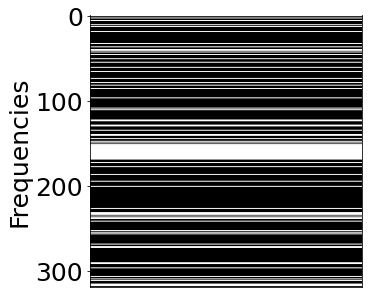

In [18]:
highmask_view = torch.sigmoid( mnet(y) ).detach()

highmask_view = mask_makebinary(raw_normalize(highmask_view,budget,threshold=0.5),threshold=0.5,sigma=False)

fullmask = mask_complete(highmask_view,320)
kplot(fullmask[0,:])

In [19]:
# highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
# highmask = highmask.repeat(5,1)

c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
        UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
        unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        UNET.train()
    # highmask_refined,unet = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
    #                   beta=1.,alpha=alpha,c=c,\
    #                   maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
    #                   lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
    #                   verbose=True,dtyp=torch.float)
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True,\
                          return_loss_only=True)
        a_ind += 1
    print('\n')
    c_ind += 1

c_ind 1 out of 4
alpha_ind 1 out of 8
loss of the input mask:  (0.08529737144708634, 0.7385496616363525)
Iter 1, rows added: 0.0, rows reducted: 64.0, current samp. ratio: 0.05
Iter 2, rows added: 9.4, rows reducted: 0.0, current samp. ratio: 0.079375
Iter 3, rows added: 20.0, rows reducted: 0.4, current samp. ratio: 0.140625
Iter 4, rows added: 2.6, rows reducted: 2.4, current samp. ratio: 0.14125
Iter 5, rows added: 9.6, rows reducted: 0.4, current samp. ratio: 0.17
Iter 6, rows added: 3.6, rows reducted: 3.6, current samp. ratio: 0.17
Iter 7, rows added: 12.6, rows reducted: 0.2, current samp. ratio: 0.20875
Iter 8, rows added: 2.4, rows reducted: 3.0, current samp. ratio: 0.206875
Iter 9, rows added: 4.2, rows reducted: 0.6, current samp. ratio: 0.218125
Iter 10, rows added: 3.8, rows reducted: 0.0, current samp. ratio: 0.23
Iter 11, rows added: 1.6, rows reducted: 0.8, current samp. ratio: 0.2325
Iter 12, rows added: 4.2, rows reducted: 0.0, current samp. ratio: 0.245625
Iter 13, 

Iter 11, rows added: 4.8, rows reducted: 4.8, current samp. ratio: 0.17
Iter 12, rows added: 4.2, rows reducted: 0.2, current samp. ratio: 0.1825
Iter 13, rows added: 1.8, rows reducted: 1.0, current samp. ratio: 0.185
Iter 14, rows added: 2.4, rows reducted: 0.8, current samp. ratio: 0.19
Iter 15, rows added: 1.8, rows reducted: 3.4, current samp. ratio: 0.185
Iter 16, rows added: 1.6, rows reducted: 1.0, current samp. ratio: 0.186875
Iter 17, rows added: 2.4, rows reducted: 0.2, current samp. ratio: 0.19375
Iter 18, rows added: 3.0, rows reducted: 0.8, current samp. ratio: 0.200625
Iter 19, rows added: 2.4, rows reducted: 2.6, current samp. ratio: 0.2
Iter 20, rows added: 2.8, rows reducted: 1.4, current samp. ratio: 0.204375
Iter 21, rows added: 3.6, rows reducted: 1.0, current samp. ratio: 0.2125
Iter 22, rows added: 1.4, rows reducted: 0.4, current samp. ratio: 0.215625
Iter 23, rows added: 3.0, rows reducted: 0.4, current samp. ratio: 0.22375
Iter 24, rows added: 1.2, rows reduct

Iter 23, rows added: 0.4, rows reducted: 1.6, current samp. ratio: 0.21625
Iter 24, rows added: 3.4, rows reducted: 0.0, current samp. ratio: 0.226875
Iter 25, rows added: 1.6, rows reducted: 1.2, current samp. ratio: 0.228125
Iter 26, rows added: 2.2, rows reducted: 0.4, current samp. ratio: 0.23375
Iter 27, rows added: 1.6, rows reducted: 0.6, current samp. ratio: 0.236875
Iter 28, rows added: 3.2, rows reducted: 0.0, current samp. ratio: 0.246875
Iter 29, rows added: 1.0, rows reducted: 1.4, current samp. ratio: 0.245625
Iter 30, rows added: 2.8, rows reducted: 0.0, current samp. ratio: 0.254375

return at Iter ind:  30
samp. ratio: 0.254375, loss of returned mask: (0.06643252223730087, 0.6633737683296204) 

alpha_ind 8 out of 8
loss of the input mask:  (0.08529738336801529, 0.7385498404502868)
Iter 1, rows added: 0.0, rows reducted: 64.0, current samp. ratio: 0.05
Iter 2, rows added: 4.2, rows reducted: 0.0, current samp. ratio: 0.063125
Iter 3, rows added: 8.0, rows reducted: 0.4,

Iter 2, rows added: 8.8, rows reducted: 0.0, current samp. ratio: 0.0775
Iter 3, rows added: 15.2, rows reducted: 0.4, current samp. ratio: 0.12375
Iter 4, rows added: 2.0, rows reducted: 1.6, current samp. ratio: 0.125
Iter 5, rows added: 6.8, rows reducted: 0.6, current samp. ratio: 0.144375
Iter 6, rows added: 5.8, rows reducted: 1.4, current samp. ratio: 0.158125
Iter 7, rows added: 7.8, rows reducted: 0.0, current samp. ratio: 0.1825
Iter 8, rows added: 1.6, rows reducted: 1.8, current samp. ratio: 0.181875
Iter 9, rows added: 4.2, rows reducted: 2.6, current samp. ratio: 0.186875
Iter 10, rows added: 1.6, rows reducted: 4.0, current samp. ratio: 0.179375
Iter 11, rows added: 6.0, rows reducted: 1.8, current samp. ratio: 0.1925
Iter 12, rows added: 4.0, rows reducted: 1.4, current samp. ratio: 0.200625
Iter 13, rows added: 3.6, rows reducted: 4.4, current samp. ratio: 0.198125
Iter 14, rows added: 4.2, rows reducted: 2.0, current samp. ratio: 0.205
Iter 15, rows added: 1.8, rows r

Iter 14, rows added: 0.4, rows reducted: 1.0, current samp. ratio: 0.178125
Iter 15, rows added: 5.6, rows reducted: 0.0, current samp. ratio: 0.195625
Iter 16, rows added: 0.6, rows reducted: 0.0, current samp. ratio: 0.1975
Iter 17, rows added: 2.2, rows reducted: 0.0, current samp. ratio: 0.204375
Iter 18, rows added: 0.2, rows reducted: 0.6, current samp. ratio: 0.203125
Iter 19, rows added: 1.8, rows reducted: 0.0, current samp. ratio: 0.20875
Iter 20, rows added: 0.8, rows reducted: 0.6, current samp. ratio: 0.209375
Iter 21, rows added: 2.8, rows reducted: 0.2, current samp. ratio: 0.2175
Iter 22, rows added: 1.8, rows reducted: 0.2, current samp. ratio: 0.2225
Iter 23, rows added: 2.6, rows reducted: 0.0, current samp. ratio: 0.230625
Iter 24, rows added: 1.8, rows reducted: 0.4, current samp. ratio: 0.235
Iter 25, rows added: 2.2, rows reducted: 0.2, current samp. ratio: 0.24125
Iter 26, rows added: 1.8, rows reducted: 0.0, current samp. ratio: 0.246875
Iter 27, rows added: 0.

Iter 28, rows added: 4.4, rows reducted: 0.0, current samp. ratio: 0.38
Iter 29, rows added: 1.0, rows reducted: 2.0, current samp. ratio: 0.376875
Iter 30, rows added: 3.8, rows reducted: 0.2, current samp. ratio: 0.388125

return at Iter ind:  30
samp. ratio: 0.388125, loss of returned mask: (0.05856165811419487, 0.596494483947754) 

alpha_ind 2 out of 8
loss of the input mask:  (0.08529742360115052, 0.7385501861572266)
Iter 3, rows added: 4.4, rows reducted: 0.0, current samp. ratio: 0.26375
Iter 4, rows added: 0.0, rows reducted: 0.4, current samp. ratio: 0.2625
Iter 5, rows added: 3.8, rows reducted: 0.6, current samp. ratio: 0.2725
Iter 6, rows added: 2.0, rows reducted: 1.2, current samp. ratio: 0.275
Iter 7, rows added: 5.2, rows reducted: 1.2, current samp. ratio: 0.2875
Iter 8, rows added: 0.6, rows reducted: 0.8, current samp. ratio: 0.286875
Iter 9, rows added: 3.4, rows reducted: 0.0, current samp. ratio: 0.2975
Iter 10, rows added: 1.0, rows reducted: 0.4, current samp. r

Iter 15, rows added: 1.8, rows reducted: 0.4, current samp. ratio: 0.31375
Iter 16, rows added: 2.8, rows reducted: 0.0, current samp. ratio: 0.3225
Iter 17, rows added: 1.4, rows reducted: 1.2, current samp. ratio: 0.323125
Iter 18, rows added: 2.6, rows reducted: 0.0, current samp. ratio: 0.33125
Iter 19, rows added: 1.2, rows reducted: 0.6, current samp. ratio: 0.333125
Iter 20, rows added: 1.6, rows reducted: 0.6, current samp. ratio: 0.33625
Iter 21, rows added: 1.4, rows reducted: 0.4, current samp. ratio: 0.339375
Iter 22, rows added: 2.6, rows reducted: 0.8, current samp. ratio: 0.345
Iter 23, rows added: 1.6, rows reducted: 2.0, current samp. ratio: 0.34375
Iter 24, rows added: 3.4, rows reducted: 0.4, current samp. ratio: 0.353125
Iter 25, rows added: 0.8, rows reducted: 2.6, current samp. ratio: 0.3475
Iter 26, rows added: 3.4, rows reducted: 0.6, current samp. ratio: 0.35625
Iter 27, rows added: 1.4, rows reducted: 2.6, current samp. ratio: 0.3525
Iter 28, rows added: 4.2, 

loss of the input mask:  (0.08529737442731858, 0.7385497093200684)
Iter 12, rows added: 0.4, rows reducted: 0.0, current samp. ratio: 0.25125
Iter 13, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.251875
Iter 14, rows added: 0.8, rows reducted: 0.6, current samp. ratio: 0.2525
Iter 15, rows added: 0.6, rows reducted: 0.2, current samp. ratio: 0.25375
Iter 16, rows added: 0.8, rows reducted: 1.0, current samp. ratio: 0.253125
Iter 17, rows added: 1.2, rows reducted: 0.6, current samp. ratio: 0.255
Iter 18, rows added: 1.2, rows reducted: 0.8, current samp. ratio: 0.25625
Iter 19, rows added: 0.8, rows reducted: 0.4, current samp. ratio: 0.2575
Iter 20, rows added: 1.2, rows reducted: 1.6, current samp. ratio: 0.25625
Iter 21, rows added: 2.0, rows reducted: 0.8, current samp. ratio: 0.26
Iter 22, rows added: 1.0, rows reducted: 1.4, current samp. ratio: 0.25875
Iter 23, rows added: 1.6, rows reducted: 1.0, current samp. ratio: 0.260625
Iter 24, rows added: 1.0, rows reduct

Iter 14, rows added: 0.4, rows reducted: 0.4, current samp. ratio: 0.25125
Iter 15, rows added: 0.6, rows reducted: 0.2, current samp. ratio: 0.2525
Iter 16, rows added: 0.8, rows reducted: 0.4, current samp. ratio: 0.25375
Iter 17, rows added: 0.8, rows reducted: 0.2, current samp. ratio: 0.255625
Iter 18, rows added: 0.8, rows reducted: 0.6, current samp. ratio: 0.25625
Iter 19, rows added: 0.6, rows reducted: 0.8, current samp. ratio: 0.255625
Iter 20, rows added: 1.4, rows reducted: 1.0, current samp. ratio: 0.256875
Iter 21, rows added: 1.4, rows reducted: 0.6, current samp. ratio: 0.259375
Iter 22, rows added: 1.2, rows reducted: 1.0, current samp. ratio: 0.26
Iter 23, rows added: 1.2, rows reducted: 2.0, current samp. ratio: 0.2575
Iter 24, rows added: 2.0, rows reducted: 1.4, current samp. ratio: 0.259375
Iter 25, rows added: 1.4, rows reducted: 0.4, current samp. ratio: 0.2625
Iter 26, rows added: 1.0, rows reducted: 2.0, current samp. ratio: 0.259375
Iter 27, rows added: 1.8,

In [20]:
# highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],budget,replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=budget,other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)

In [22]:
# full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
# (gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')

print(rand_l2)
print(lowf_l2)
# print(gred_l2)

mode = sigpy
0.09006276875734329
0.06691977754235268


In [ ]:
# mnet_loss = mask_eval(full_highmask,xstar,mode='UNET',UNET=UNET)
# rand_loss = mask_eval(full_randmask,xstar,mode='UNET',UNET=UNET)
# lowf_loss = mask_eval(full_lowfmask,xstar,mode='UNET',UNET=UNET)
# print('mode = UNet')
# mnet_loss = mask_eval(full_highmask,xstar,mode='sigpy')
(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
(gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')
# print(mnet_loss)

print(rand_l2)
print(lowf_l2)
print(gred_l2)

NameError: name 'gred_l2' is not defined

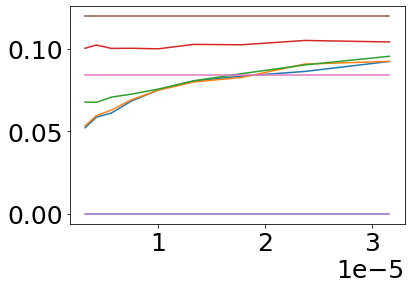

In [9]:
plt.figure()
plt.plot(alpha_grid,l2loss)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,label='greedy')
plt.title('l2 loss of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,hfen)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,sparsity,label='actual')
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')

Text(0.5, 0, 'alpha')

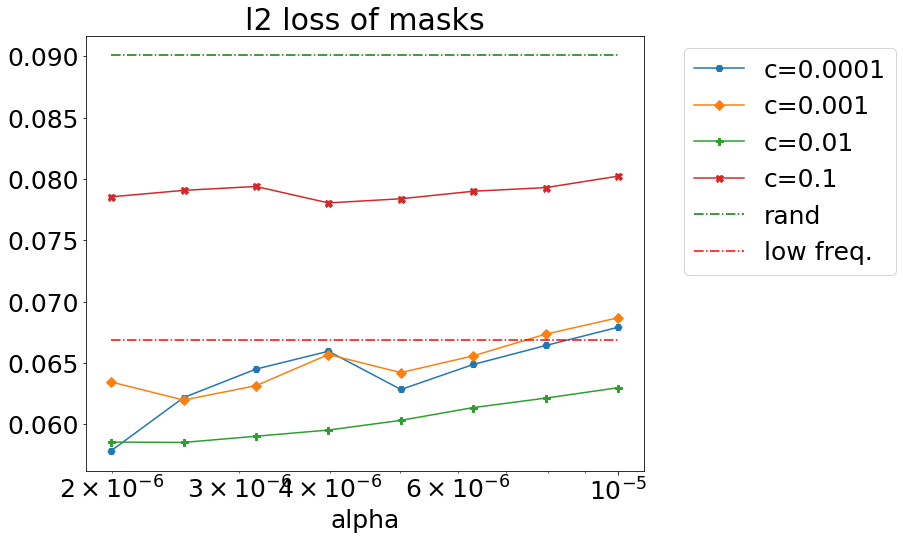

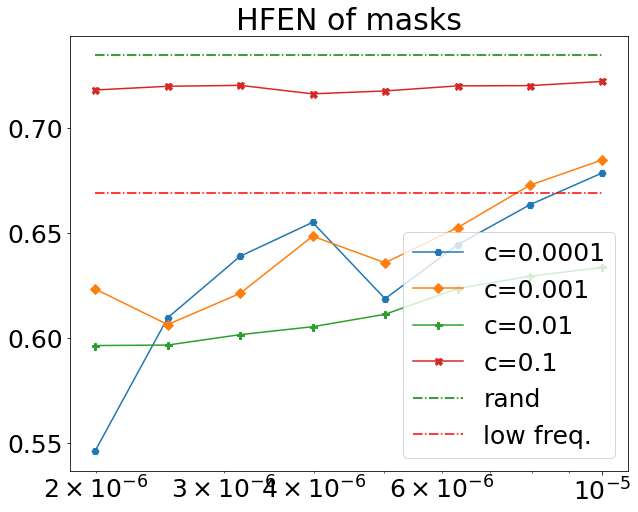

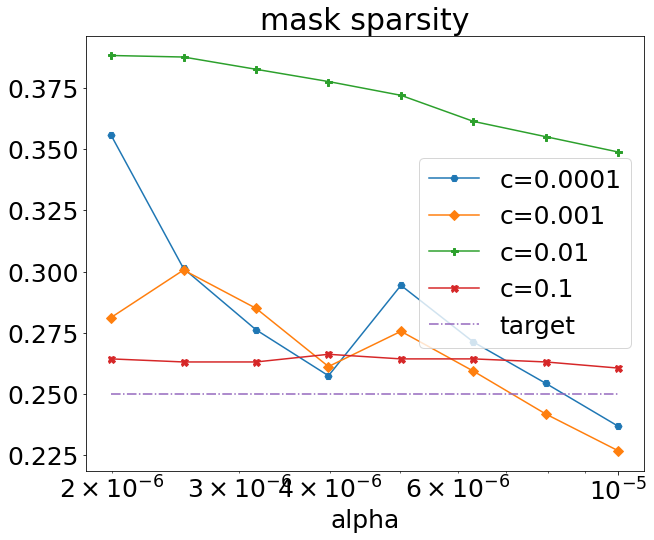

In [23]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,linestyle='-.',color='g',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,linestyle='-.',color='r',label='low freq.')
# plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,color='k',label='greedy')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best',bbox_to_anchor=(1.05, 1))

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='g',linestyle='-.',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='r',linestyle='-.',label='low freq.')
# plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,color='k',label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),linestyle='-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

In [25]:
10**(-5.4)

3.981071705534969e-06

In [24]:
np.log10(alpha_grid[3])

-5.4

In [ ]:
from sigpy.mri.app import TotalVariationRecon
xstar = imgs[0,:,:]/torch.max(torch.abs(imgs[0,:,:].flatten()))
imgHeg, imgWid = xstar.shape[0], xstar.shape[1]
mps = np.ones((1,imgHeg,imgWid))
imgind = 15

NN = 15
Lambda_grid = 10**(np.linspace(-4,-2.5,NN))
errors = np.zeros((NN))

y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'),dim=(0,1))    
z = torch.zeros(y.shape).to(y.dtype)
z[masks[imgind,:]==1,:] = y[masks[imgind,:]==1,:]  
y_tmp = z.view(-1,imgHeg,imgWid).numpy()

xstar = xstar.numpy()

ind = 0
for Lambda in Lambda_grid:    
    x_tmp = np.fft.ifftshift( np.abs(TotalVariationRecon(y_tmp, mps, Lambda, show_pbar=False).run()) )  
    errors[ind] = np.linalg.norm(x_tmp - xstar,'fro')/np.linalg.norm(xstar,'fro')
    ind += 1
    
plt.figure()
plt.plot(Lambda_grid,errors)
plt.xscale('log')
plt.show()

### tune weight initialization function

In [ ]:
def mnet_weights_init(m):
    classname = m.__class__.__name__
    print(m)
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# reload(utils)
# from utils import mnet_weights_init

In [ ]:
corefreq = 8
budget = 32

mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(mnet_weights_init)
# mnet.eval()
mnet(torch.randn(1,2,320,320))

### old tests

In [ ]:
from mask_backward_v3 import ThresholdBinarizeMask

In [ ]:
binarize = ThresholdBinarizeMask.apply
x = torch.tensor([0.5,-0.5],requires_grad=True)

In [ ]:
y = binarize(torch.sigmoid(3*x))
ystar = torch.tensor([0.,1.])
print(y)

In [ ]:
loss = 1/2*torch.norm(y - ystar,p=2)
optimizer = optim.SGD([{'params': x}], lr=1e-2, momentum=0)
optimizer.zero_grad()
loss.backward()

In [ ]:
x.grad

In [ ]:
data_gt = np.load('/home/huangz78/data/data_gt.npz')
picind = np.random.randint(199)
xstar = data_gt['imgdata'][:,:,27]
xstar = xstar/np.max(np.abs(xstar))
# highmask = datafornn['labels'][picind,:]
plt.figure()
plt.imshow(xstar)
plt.colorbar()
plt.show()

In [ ]:
# reload(maskbackward)
# from maskbackward import mask_backward

#mode UNET:

reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

dtyp = torch.float
# unroll_block = 8; Lambda=6.1e-4; rho=1e1

# base = .05; expand = .15
# highmask = torch.zeros((round(320*(1-base))),dtype=torch.double)
# highmask[np.random.choice(round(320*(1-base)),round(320*expand),replace=False)] = 1

highmask = mask_filter(fullmask,base=round(320*0.05),roll=True)
print(highmask.shape)

In [ ]:
n_channels = 1
UNET =  UNet(n_channels=n_channels,n_classes=n_channels,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_' + str(n_channels) + '.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
UNET.eval()

In [ ]:
## quick comparison between ifft recon and unet recon
imgHeg = 320; imgWid = 320
fullmask = torch.tensor( mask_complete(highmask,imgHeg,dtyp=torch.float) )
kplot(fullmask)
print('sparsity of fullmask = ',fullmask.sum().item()/imgHeg)

In [ ]:
xstar = torch.tensor(xstar,dtype=dtyp)
DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'))
z = torch.fft.ifftshift(torch.tensordot(torch.diag(fullmask).to(DTyp),y,dims=([1],[0])))
kplot(y,roll=False,log=True)
kplot(z,roll=True,log=True)

In [ ]:
imgHeg = 320; imgWid = 320
x_ifft = torch.abs(F.ifftn(z,dim=(0,1),norm='ortho')).to(dtyp)
x_unet = UNET(x_ifft.view(1,1,imgHeg,imgWid)).detach()

print('error of x_ifft = ', torch.norm(torch.flatten(x_ifft)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )
print('error of x_unet = ', torch.norm(torch.flatten(x_unet)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )

In [ ]:
from sigpy.mri.app import TotalVariationRecon
NN = 50
Lambda_grid = 10**np.linspace(-3.5,-3,NN)
errRec = np.zeros((NN))
ind = 1

mps  = np.ones((1,imgHeg,imgWid))
y_sp = np.reshape(z.numpy(),(-1,imgHeg,imgWid))
for Lambda in Lambda_grid:
# Lambda = 10**(-6.31) 
# Lambda = 10**(-3.2755) # np.log10(Lambda_grid[np.argmin(errRec)])
    print('{} out of {}'.format(ind,NN))
    x_sp = np.fft.fftshift( np.abs(TotalVariationRecon(y_sp, mps, Lambda,show_pbar=False).run()) ) 
    x_sp = torch.tensor(x_sp)
    errRec[ind-1] = torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro')
    ind += 1
#     print('error of x_sp = ', torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro'))

plt.figure()
plt.xscale('log')
plt.plot(Lambda_grid,errRec)

In [ ]:
np.linspace(-6,-4,gridnum)[8]

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

maxIter = 200
gridnum = 10
alpha_grid = 10**np.linspace(-4.6,-4.5,gridnum)
sr_rec = np.zeros((gridnum))
mloss_rec = np.zeros(gridnum)

ind = 0
for alpha in alpha_grid:
    print('[{}/{}]  alpha {}'.format(ind+1,gridnum,alpha))
    highmask_refined,refine_mloss,init_loss = mask_backward(highmask,xstar,\
                          beta=1., alpha=alpha,maxIter=maxIter,seed=0,break_limit=maxIter//2,\
                          lr=5e-4,mode='UNET',\
                          verbose=False,dtyp=dtyp)
    print('Difference between masks: \n',highmask_refined - highmask)
#     print('Refined mask is: \n',highmask_refined)
    mloss_rec[ind] = refine_mloss
    sr_rec[ind] = (torch.sum(highmask_refined).item() + 24)/320
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,mloss_rec,label='refined')
plt.scatter(alpha_grid,init_loss*np.ones(mloss_rec.shape),label='init.')
plt.title('mask loss')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.scatter(alpha_grid,sr_rec,label='refined')
plt.scatter(alpha_grid,0.25*np.ones(mloss_rec.shape),label='init.')
plt.title('mask sampling ratio')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### mask binarize test

In [ ]:
from torch.autograd import Function
class ThresholdBinarizeMask(Function):
    def __init__(self):
        """
            Straight through estimator.
            The forward step binarizes the real-valued mask.
            The backward step estimate the non differentiable > operator using sigmoid with large slope (10).
        """
        super(ThresholdBinarizeMask, self).__init__()

    @staticmethod
    def forward(ctx, input):
        batch_size = len(input)
        results = [] 

        for i in range(batch_size):
            x = input[i:i+1]
            result = (x > .5).float()
            results.append(result)

        results = torch.cat(results, dim=0)
#         ctx.save_for_backward(input)
        return results  

    @staticmethod
    def backward(ctx, grad_output):
        slope = 1
#         input = ctx.saved_tensors

        # derivative of M
        current_grad = slope

        return current_grad * grad_output

In [ ]:
threshold = ThresholdBinarizeMask.apply

In [ ]:
x = torch.tensor([.1,.3,.7,.9,.6,.5,.21,.43])
x.requires_grad = True
b = threshold(x)

In [ ]:
y = torch.tensor([1., 1., 1., 1., 0., 1., 0., 1.])
loss = torch.norm((y-b),p=2)**2

In [ ]:
optimizer = optim.SGD([{'params': x}], lr=1e-2)

In [ ]:
optimizer.zero_grad()
loss.backward()
print('old x: ', x)
print('grad: ', x.grad)
optimizer.step()
print('updated x: ', x)

### arXiv

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward

# mode ADMM:

highmask = torch.zeros((round(320*0.9)))
highmask[np.random.choice(round(320*0.9),int(320*.1),replace=False)] = 1

naive_mloss = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
highmask_refined,refine_mloss = mask_backward(highmask,xstar,\
                          beta=1., alpha=1e1,maxIter=200,unroll_block=unroll_block,seed=0,break_limit=100,\
                          lr=5e-4,mode='ADMM',Lambda=Lambda,rho=rho,\
                          verbose=True,perturb=False,perturb_freq=5,eps=1e-2)

In [ ]:
# vary sampling ratio, observe RMSE for the same image.
reload(mask_backward_new)
from mask_backward_new import mask_backward

base=0.1
r_grid = np.array([0.1,0.15,0.2])
naive_mloss = np.zeros((r_grid.size))
refine_mloss = np.zeros((r_grid.size))

sampRatio = np.zeros((r_grid.size))

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/3)

np.random.seed(0)

ind = 0
for r in r_grid:
    print('\n r {}, the {} item out of {}'.format(r,ind+1,r_grid.size))
    highmask = torch.zeros((round(320*(1-base))))
    highmask[np.random.choice(round(320*(1-base)),int(320*r),replace=False)] = 1
    
    naive_mloss[ind] = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
    highmask_refined,refine_mloss[ind] = mask_backward(highmask,xstar,seed=0,\
                              beta=1., alpha=9.5e0,maxIter=maxIter,unroll_block=unroll_block,break_limit=break_limit,\
                              lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                              verbose=True,perturb=False,perturb_freq=5,eps=1e-2)
    sampRatio[ind] = (highmask_refined.sum().item() + round(320*0.1))/320
    ind += 1

In [ ]:
print('sampRatio: ',sampRatio)
plt.figure()
plt.scatter(r_grid,naive_mloss,label='naive')
plt.scatter(sampRatio,refine_mloss,label='refined')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

In [ ]:
## find a good alpha for l1 penalty
reload(mask_backward_new); reload(utils);
from mask_backward_new import mask_backward
alpha_grid = np.linspace(1,10,10)
sparsity_ = np.zeros(alpha_grid.size)
change_count = np.zeros(alpha_grid.size)

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/2)
# add samp. ratio. = .1 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?

base = 0.05
additional = 0.125

highmask = torch.zeros((round(320*(1-base))))
highmask[np.random.choice(round(320*(1-base)),round(320*additional),replace=False)] = 1

ind = 0
for alpha in alpha_grid:
    print('\n\talpha = {}'.format(alpha))
    highmask_refined,_ = mask_backward(highmask,xstar,\
                  beta=1, alpha=alpha,maxIter=maxIter,unroll_block=unroll_block,seed=0,break_limit=break_limit,\
                  lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                  perturb=False,perturb_freq=10,verbose=True)
    sparsity_[ind] = mask_complete(highmask_refined.to(torch.double),320).sum().item()/320
    change_count[ind] = torch.abs(highmask_refined - highmask).sum().item()
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,sparsity_,label='end')
plt.scatter(alpha_grid,(base+additional)*np.ones(alpha_grid.size),label='start')
plt.title('sparsity')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

plt.figure()
plt.scatter(alpha_grid,change_count)
# plt.xscale('log')
plt.title('change count')

In [ ]:
naive_mloss = mask_eval(mask_complete(highmask,imgHeg,dtyp=dtyp),xstar,mode='UNET',UNET=UNET,dtyp=dtyp) * 100
print('naive mask loss = ',naive_mloss)

In [ ]:
### verify that UNET works fine
z = apply_mask(full_gredmask,yfull,mode='c')
xs = torch.abs(F.ifftn(F.ifftshift(z),dim=(1,2),norm='ortho'))
xs = torch.reshape(xs,(xs.shape[0],1,xs.shape[1],xs.shape[2]))

UNET.eval()
imgind = 0
xrecon = UNET(xs)
plt.figure()
plt.title('recon')
plt.imshow(xrecon.detach().numpy()[imgind,0,:,:])
plt.colorbar()
plt.show()

plt.figure()
plt.title('gt')
plt.imshow(xstar.detach().numpy()[imgind,:,:])
plt.colorbar()
plt.show()
print(torch.norm(xrecon[imgind,0,:,:]-xstar[imgind,:,:],'fro')/torch.norm(xstar[imgind,:,:],'fro').item())

In [ ]:
reload(utils)
from utils import hfen

In [ ]:
torch.squeeze(xrecon)[0,:,:].shape

In [ ]:
hfen(torch.squeeze(xrecon)[imgind,:,:],xstar[imgind,:,:],base=0)